In [1]:
import jax
import jax.numpy as jnp
import pandas
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
# read the test data
df = pandas.read_csv("data/dataset.csv")
df = df[df.fold == -1]

features = sorted([
    "H_modelled",
    "H_modelled_grad", 
    "H_modelled_lapl", 
    "v_modelled",
    "v_modelled_grad",
    "v_modelled_lapl",
    "boundary_proximity",
    "elevation1",
    "elevation1_gradient", 
    "elevation1_laplacian",
    "elevation2_gradient",
    "elevation2_laplacian",
    "elevation_diff",
])

feature_idxs = {feature: idx for idx, feature in enumerate(features)}
target = "H"

In [3]:
# normalise test data
with open("data/stats.pickle", "rb") as src:
    feature_mins, feature_maxs = pickle.load(src)

df_norm = df.copy()

for feature in features + ["H"]:
    vmin = feature_mins[feature]
    vmax = feature_maxs[feature]
    feature_norm = (df_norm[feature] - vmin) / (vmax - vmin)
    df_norm[feature] = feature_norm

In [4]:
# load the model params and hyperparameters
# adjust the paths as needed
with open("params/params.pickle", "rb") as src:
    params = pickle.load(src)
with open("hyperparameters/hyperparameters.pickle", "rb") as src:
    hyperparameters = pickle.load(src)

activation_fuction = {
    "swish": jax.nn.swish,
    "relu": jax.nn.relu,
    "softplus": jax.nn.softplus,
    "elu": jax.nn.elu,
}[hyperparameters["activation_function"]]

In [5]:
# define model again (in practice, the model definition would be moved to a separate file to avoid code duplication, as well as other parts)
def build_mlp(activation, final_activation=None, squeeze=False):
    if final_activation is None:
        def linear(x):
            return x
        final_activation = jax.jit(linear)
        
    def mlp(params, x):
        for w, b in params[:-1]:
            x = jnp.dot(w, x) + b
            x = activation(x)
        w, b = params[-1]
        y = jnp.dot(w, x) + b
        y = final_activation(y)
        if squeeze:
            y = jnp.squeeze(y)
        return y

    return jax.jit(mlp)


def build_dathice(mlp_bcs, mlp):
    def dathice(params, x):
        mlp_bcs_params, mlp_params = params
        p = jnp.array([x[_] for _ in sorted(x.keys())])
        mlp_bcs_output = mlp_bcs(mlp_bcs_params, p)
        mlp_output = mlp(mlp_params, p)
        d = x["boundary_proximity"]
        H_modelled = x["H_modelled"]
        bcs_factor = d * mlp_bcs_output
        H_corrected = H_modelled + mlp_output
        H_constrained = jax.nn.relu(H_corrected)
        y = bcs_factor * H_constrained
        return y
        
    return jax.jit(dathice)


mlp_bcs = build_mlp(
    activation_fuction, 
    final_activation=jax.nn.softplus, 
    squeeze=True
)
mlp = build_mlp(
    activation_fuction, 
    squeeze=True
)
dathice = build_dathice(mlp_bcs, mlp)

mlp_bcs_batched = jax.vmap(mlp_bcs, in_axes=(None, 0))
mlp_batched = jax.vmap(mlp, in_axes=(None, 0))
dathice_batched = jax.vmap(dathice, in_axes=(None, 0))

In [6]:
# run the model on the test data
def convert_to_jax_xy_pair(df, target=target):
    x = {_: jnp.array(df[_]) for _ in features}
    y = jnp.array(df[target])    
    return x, y


x, _ = convert_to_jax_xy_pair(df_norm)
pred = dathice_batched(params, x)


# a helper function to 'denormalise' values back
def denorm(vals, column, vmin=None, vmax=None):
    if vmin is None:
        vmin = feature_mins[column]
    if vmax is None:
        vmax = feature_maxs[column]
    denormed = vals * (vmax - vmin) + vmin
    return denormed


pred = denorm(pred, "H")

In [7]:
# evaluate the results
def rmse(true, pred):
    return np.sqrt(np.nanmean((true - pred) ** 2))


def r_squared(true, pred):
    mean_observed = np.mean(true)
    sst = np.sum((true - mean_observed) ** 2)
    ssr = np.sum((true - pred) ** 2)
    return 1 - ssr / sst

In [8]:
def plot_scatter(x, y, ax, xlabel, ylabel, vmin=0, vmax=200):
    n = len(x)
    linear_fit_slope = (n * np.sum(x * y) - np.sum(x) * np.sum(y)) / (n * np.sum(x**2) - np.sum(x)**2)
    linear_fit_bias = (np.sum(y) * np.sum(x**2) - np.sum(x) * np.sum(x * y)) / (n * np.sum(x**2) - np.sum(x)**2)
    linear_fit_xs = np.arange(vmin, vmax, 1)
    linear_fit_ys = linear_fit_slope * linear_fit_xs + linear_fit_bias
    
    ax.plot([vmin, vmax], [vmin, vmax], color="lightgreen", linewidth=2, label="Ideal", zorder=-2)
    ax.plot(linear_fit_xs, linear_fit_ys, color="black", linewidth=0.5, alpha=0.5, label="Linear fit", zorder=-1)
    
    ax.scatter(x, y, s=2, alpha=0.5)

    _rmse = rmse(y, x)
    _r_squared = r_squared(y, x)
    ax.text(1.0, 0, f"R$^2$ = {_r_squared:.2f}", ha="right", va="bottom", transform=ax.transAxes)
    ax.text(1.0, 0.065, f"RMSE = {_rmse:.2f}", ha="right", va="bottom", transform=ax.transAxes)
    
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    
    ax.set_xlim(vmin, vmax)
    ax.set_ylim(vmin, vmax)
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_position(("outward", 6))
    ax.spines["bottom"].set_position(("outward", 6))
    
    ax.legend(frameon=False, loc="upper left")

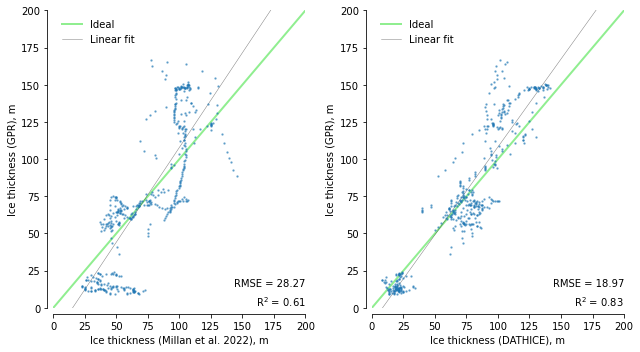

In [9]:
_, axs = plt.subplots(ncols=2, figsize=(9, 5))

plot_scatter(df["H_modelled"], df["H"], axs[0], "Ice thickness (Millan et al. 2022), m", "Ice thickness (GPR), m")
plot_scatter(pred, df["H"], axs[1], "Ice thickness (DATHICE), m", "Ice thickness (GPR), m")

plt.tight_layout()
plt.show()